In [2]:
import os
import monai
import torch
import numpy as np
import pandas as pd
import tqdm as tqdm
from monai.data import decollate_batch
from torch.utils.data import DataLoader
from monai.metrics import ROCAUCMetric
from monai.utils import set_determinism
import matplotlib.pyplot as plt
import PIL
from monai.transforms import LoadImage, Resize, NormalizeIntensity,RandRotate,RandFlip,RandZoom,Compose,Activations, AsDiscrete,EnsureChannelFirst
from monai.networks.nets import DenseNet121

/home/marioverd/anaconda3/envs/MONAI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
set_determinism(seed =  0)
data_dir  = "/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/"
class_names = ["false","true"]   #dove true sono brain e false no brain 
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir,class_names[i],x) for x in os.listdir(os.path.join(data_dir,class_names[i])) if x.endswith("png")] for i in range(len(class_names))
    
                ]   #lista di liste, 0 contiene tutti i file labellati con no-brain.1 i brain

image_file_list = []
image_class = []


for i in range(len(class_names)) :
    image_file_list.extend(image_files[i])
    image_class.extend([i]*len(image_files[i]))
    
image_dictionary = {
                        "image" : image_file_list,
                        "label" : image_class
}

df = pd.DataFrame.from_dict(image_dictionary).to_csv('./image.csv')

num_total = len(image_class) 



NameError: name 'set_determinism' is not defined

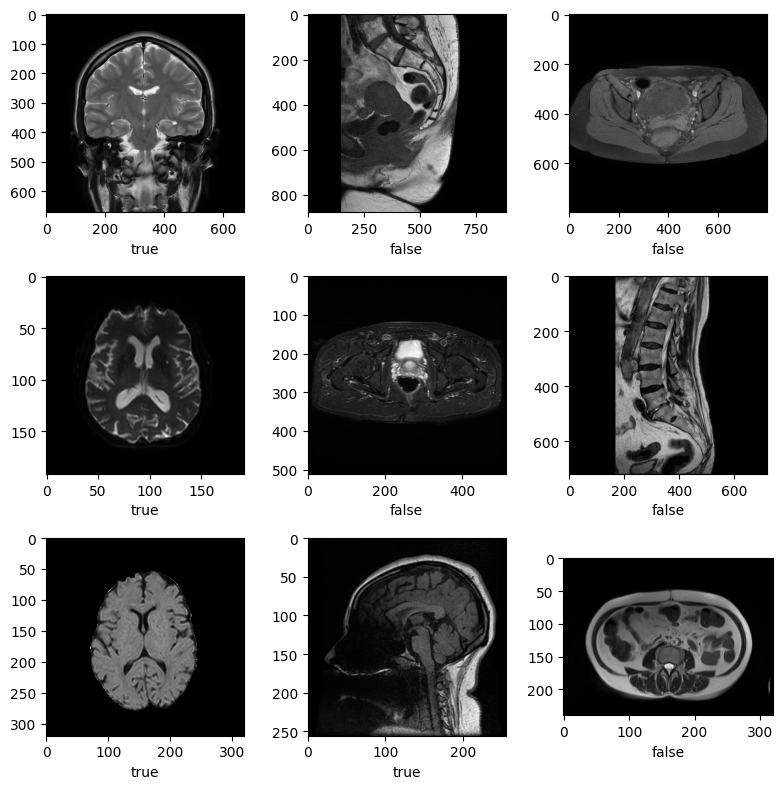

In [3]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()



Splitto il dataset 70 test 20 validation 10 test 

In [4]:
val_frac = 0.2
test_frac = 0.1
length = len(image_file_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_file_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_file_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_file_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]


print("Training count : {} , Validation count : {} ,  Test count : {} ".format(len(train_x), len(val_x), len(test_x)))

Training count : 1441 , Validation count : 411 ,  Test count : 205 


In [26]:
train_dictionary = {
    "image_path" : train_x,
    "label" : train_y
}

validation_dictionary = {
    "image_path" : val_x,
    "label" : val_y
}

test_dictionary = {
    "image_path" : test_x,
    "label" : test_y
}

pd.DataFrame.from_dict(train_dictionary).to_csv("./Train.csv")
pd.DataFrame.from_dict(validation_dictionary).to_csv("./Validation.csv")
pd.DataFrame.from_dict(test_dictionary).to_csv("./Test.csv")



In [5]:
train_transforms = Compose(
    [
        LoadImage(image_only=True,ensure_channel_first= True),
        Resize((256,256)),
        NormalizeIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True),EnsureChannelFirst() ,NormalizeIntensity(),Resize((256,256))])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [6]:
class BrainClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = BrainClassificationDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True,num_workers=5)

val_ds = BrainClassificationDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=10,num_workers=5)

test_ds = BrainClassificationDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=10,num_workers=5)

In [ ]:
train_images, train_labels = next(iter(train_loader))
print(f"Images batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=4, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 80
val_interval = 1
auc_metric = ROCAUCMetric()

In [10]:
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

In [10]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_val = []
validation_loss =  []
metric_values = []
root_dir = "./model_weight/"
#early stopping
val_loss = []
last_loss = 100
patience = 2
triggertimes =  0
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/80
1/36, train_loss: 0.5675
2/36, train_loss: 0.5773
3/36, train_loss: 0.4663
4/36, train_loss: 0.5235
5/36, train_loss: 0.5434
6/36, train_loss: 0.4658
7/36, train_loss: 0.4555
8/36, train_loss: 0.5194
9/36, train_loss: 0.5146
10/36, train_loss: 0.5053
11/36, train_loss: 0.5534
12/36, train_loss: 0.5384
13/36, train_loss: 0.4961
14/36, train_loss: 0.6000
15/36, train_loss: 0.4917
16/36, train_loss: 0.6063
17/36, train_loss: 0.5365
18/36, train_loss: 0.4700
19/36, train_loss: 0.4602
20/36, train_loss: 0.5819
21/36, train_loss: 0.4719
22/36, train_loss: 0.4613
23/36, train_loss: 0.4873
24/36, train_loss: 0.5095
25/36, train_loss: 0.5175
26/36, train_loss: 0.6792
27/36, train_loss: 0.5003
28/36, train_loss: 0.4329
29/36, train_loss: 0.5408
30/36, train_loss: 0.4807
31/36, train_loss: 0.5978
32/36, train_loss: 0.4497
33/36, train_loss: 0.5761
34/36, train_loss: 0.4875
35/36, train_loss: 0.5662
36/36, train_loss: 0.5215
37/36, train_loss: 0.6286
epoch 1 average loss: 0.5

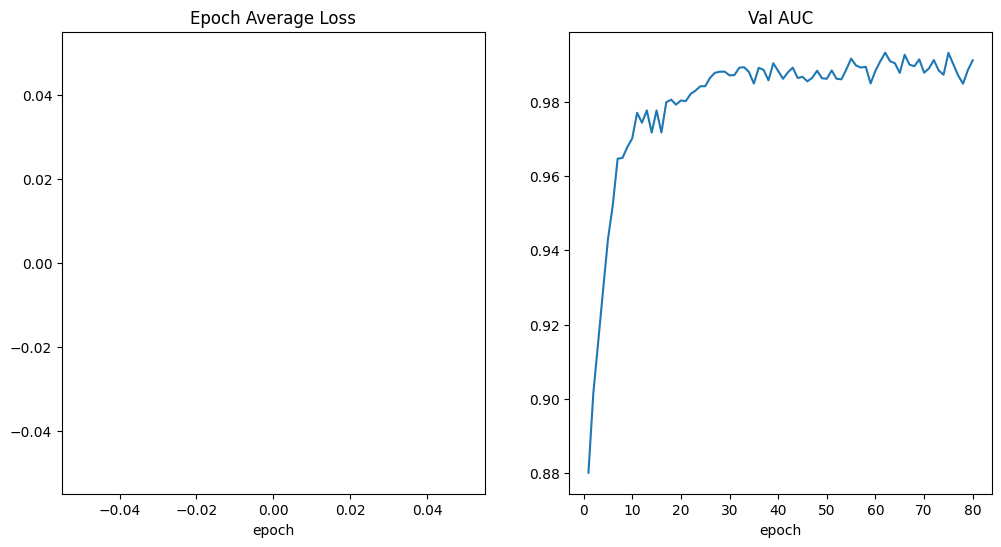

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_val
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig("./risultati/Validation.png",dpi =400)
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
#from mosaico import mosaico
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
save_name = list()
lab = list()
pr = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
            if test_labels[i] != pred[i].item() :
                save_name.append(pred[i].meta["filename_or_obj"])
                lab.append(test_labels[i])
                pr.append(pred[i])
C = confusion_matrix(y_true, y_pred)
ROC = roc_auc_score(y_true, y_pred)


0.9578083237877052
['/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/true/1.3.46.670589.11.37187.5.0.6416.2017013020135109972.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/true/1.3.46.670589.11.37187.5.0.6416.2017013020135109972.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/true/1.3.46.670589.11.37187.5.0.6416.2017013020135109972.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/true/1.3.46.670589.11.37187.5.0.6416.2017013020135109972.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/false/1.3.46.670589.11.37187.5.0.9960.2015090107361921000.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/false/1.3.46.670589.11.37187.5.0.9960.2015090107361921000.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/false/1.3.46.670589.11.37187.5.0.9960.2015090107361921000.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazione/true/1.3.46.670589.11.17524.5.0.7804.2011080110291190133.png', '/mnt/databaseRICERCA_SDN/ONWAY/PACS/Classificazi

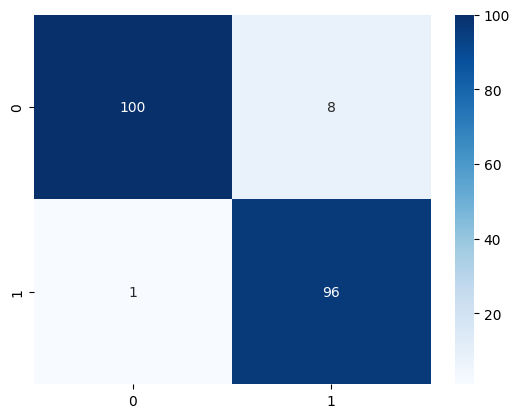

In [24]:
sns.heatmap(C, annot=True, fmt= "",cmap = "Blues")
print(ROC)
print(save_name)